In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
args = {'lr':0.01,
        'epochs':1000,
        'noise':0,
        'train size':0.7,
        'spec scale':10**12
        }

In [3]:
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Prepare Data

In [4]:
df = pd.read_excel('wide_range.xlsx')

In [5]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [6]:
X = X.apply(lambda x: x*args['spec scale'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

In [8]:
X_train.index = range(len(X_train))
X_test.index = range(len(X_test))

In [9]:
X_train

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.047328,0.044030,0.062621,0.050627,0.071193,0.068130,0.101914,0.075729,0.108325,0.133987,...,3.652357,3.706860,3.754378,3.791491,3.816109,3.819172,3.783524,3.692427,3.557224,3.432674
1,0.038770,0.035673,0.050047,0.040308,0.056641,0.054457,0.082382,0.062676,0.091149,0.114388,...,2.320425,2.355479,2.389728,2.419447,2.441954,2.450765,2.434611,2.382484,2.301435,2.226764
2,0.017471,0.015108,0.019534,0.015249,0.021160,0.020663,0.033139,0.028438,0.044417,0.059315,...,1.783106,1.818651,1.850644,1.877459,1.898089,1.907974,1.898374,1.860607,1.800060,1.744286
3,0.024575,0.020517,0.025340,0.019283,0.026321,0.025631,0.041952,0.037789,0.060454,0.082459,...,4.617065,4.680924,4.734778,4.774832,4.798921,4.795918,4.744459,4.623791,4.448374,4.286812
4,0.012262,0.010760,0.014171,0.011194,0.015674,0.015384,0.024641,0.020957,0.032692,0.043657,...,1.639148,1.670154,1.699314,1.724537,1.744379,1.754398,1.746490,1.712636,1.657755,1.607205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,0.008816,0.007552,0.009605,0.007467,0.010369,0.010237,0.016819,0.015040,0.024138,0.032982,...,1.737692,1.768599,1.798230,1.824086,1.844388,1.854326,1.845326,1.808934,1.750374,1.696432
1536,0.022660,0.019827,0.026071,0.020487,0.028498,0.027720,0.043868,0.036680,0.056381,0.074280,...,1.875067,1.911222,1.943955,1.971422,1.992454,2.002216,1.991539,1.951336,1.887281,1.828272
1537,0.054368,0.049658,0.069249,0.055489,0.077627,0.074266,0.111904,0.084833,0.122915,0.153867,...,5.344826,5.409761,5.465227,5.505966,5.528740,5.520424,5.456460,5.313137,5.107256,4.917666
1538,0.017072,0.014896,0.019520,0.015351,0.021409,0.020917,0.033378,0.028303,0.043981,0.058593,...,2.570995,2.615463,2.655006,2.687193,2.710532,2.718533,2.698864,2.639391,2.547993,2.463787


# Design Models

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 45)
        self.lin2 = nn.Linear(45, 60)
        self.lin3 = nn.Linear(60, 75)
        self.lin4 = nn.Linear(75, 60)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = self.lin_fin(x)
        return x

In [11]:
input_size = len(X_train.columns)
output_size = 1

# store models in descending order (11, 10, 9...)
models = []
for i in range(11):
    models.append(Net(input_size+i, output_size))

# Training Loops

In [12]:
learning_rate = args['lr']
criterion = nn.L1Loss()

In [13]:
best_losses = []

for i in range(11):
    best_loss = np.inf
    best_epoch = 0

    print(f'Layer {11-i}')

    optimizer = torch.optim.Adam(models[i].parameters(), lr=learning_rate)
    model = models[i]

    inputs = df_to_tensor(X_train)
    print(f'i:{i}')
    outputs = df_to_tensor(y_train.iloc[:,10-i]).reshape(-1,1)

    for epoch in range(args['epochs']):
        # empty gradients
        optimizer.zero_grad()

        # forward pass
        pred = model(inputs)

        # loss
        loss = criterion(pred, outputs)

        # backward pass
        loss.backward()
        
        # update
        optimizer.step()

        if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch + 1

    best_losses.append(best_loss.item())
    
    X_train[f'layer {11-i} predictions'] = pd.DataFrame(pred.detach().numpy())
    print(f'best loss: {best_loss} in epoch {best_epoch}\n')


Layer 11
epoch: 100, loss = 24.39298439025879
epoch: 200, loss = 11.22595500946045
epoch: 300, loss = 20.23691749572754
epoch: 400, loss = 38.79313278198242
epoch: 500, loss = 7.372354507446289
epoch: 600, loss = 11.783175468444824
epoch: 700, loss = 7.030883312225342
epoch: 800, loss = 6.32956075668335
epoch: 900, loss = 6.578897476196289
epoch: 1000, loss = 6.393057346343994
best loss: 3.8785574436187744 in epoch 973

Layer 10
epoch: 100, loss = 11.932432174682617
epoch: 200, loss = 45.86863708496094
epoch: 300, loss = 10.738485336303711
epoch: 400, loss = 10.022048950195312
epoch: 500, loss = 9.671570777893066
epoch: 600, loss = 9.157888412475586
epoch: 700, loss = 9.280384063720703
epoch: 800, loss = 8.556611061096191
epoch: 900, loss = 8.413856506347656
epoch: 1000, loss = 8.231619834899902
best loss: 8.010851860046387 in epoch 948

Layer 9
epoch: 100, loss = 8.25389575958252
epoch: 200, loss = 8.223359107971191
epoch: 300, loss = 7.09572172164917
epoch: 400, loss = 6.416841983795

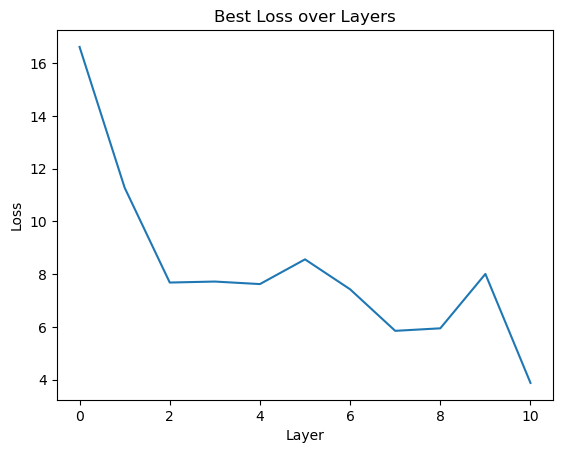

In [14]:
best_losses.reverse()
plt.plot(best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Layer")
plt.ylabel("Loss")
plt.show()

# Testing

In [15]:
def get_predictions(X_test):
    df = X_test.copy()

    predictions = []

    for i in range(11):
        inputs = df_to_tensor(df)
        pred = models[i](inputs)

        predictions.append(pred)
        df[f'layer {11-i} predictions'] = pd.DataFrame(pred.detach().numpy())

    return df.loc[:, 'layer 11 predictions':'layer 1 predictions'], predictions

In [16]:
def test_models(X_test):
    _, predictions = get_predictions(X_test)

    layer = 11
    for pred in predictions:
        actual = df_to_tensor(y_test.iloc[:,layer-1]).reshape(-1,1)
        loss = criterion(pred, actual)
        print(f'layer {layer} loss: {loss:.3f}')
        layer -= 1


In [17]:
test_models(X_test)

layer 11 loss: 3.888
layer 10 loss: 6.857
layer 9 loss: 5.533
layer 8 loss: 6.861
layer 7 loss: 7.606
layer 6 loss: 11.499
layer 5 loss: 12.410
layer 4 loss: 14.754
layer 3 loss: 18.468
layer 2 loss: 14.063
layer 1 loss: 29.197
